In [1]:
!pip install -q numpoly pytensor chaospy quantecon

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import chaospy as cp
from scipy.stats import skew, kurtosis

plt.style.use('seaborn-v0_8-darkgrid')
np.bool = bool

In [3]:
# Define the parameters for the RBC (Real Business Cycle) model
class RBCParameters:
    def __init__(self, alpha=0.36, beta=0.96, delta=0.08, rho=0.9, sigma=0.02):
        """
        Initialize the key parameters of the RBC model.

        Parameters:
        alpha (float): Capital share in production.
        beta (float): Discount factor.
        delta (float): Depreciation rate of capital.
        rho (float): Autoregressive coefficient for productivity shocks.
        sigma (float): Standard deviation of productivity shocks.
        """
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.rho = rho
        self.sigma = sigma
        self.k_ss = self.compute_steady_state_capital()  # Compute steady-state capital

    def compute_steady_state_capital(self):
        """
        Compute the steady-state level of capital.

        Returns:
        float: Steady-state capital stock.
        """
        return ((self.alpha * self.beta) / (1 - self.beta * (1 - self.delta))) ** (1 / (1 - self.alpha))

In [4]:
# Define the stochastic productivity shock in the model
class ProductivityShock:
    def __init__(self, params: RBCParameters, poly_order=3):
        """
        Initialize the productivity shock process.

        Parameters:
        params (RBCParameters): The RBC model parameters.
        poly_order (int): Polynomial order for stochastic expansion (PCE).
        """
        self.rho = params.rho
        self.sigma = params.sigma
        self.epsilon_dist = cp.Normal(0, self.sigma)  # Normally distributed shock
        self.poly_expansion = cp.expansion.stieltjes(poly_order, self.epsilon_dist)[0]  # Orthogonal polynomial expansion

    def generate_shock(self, size=1):
        """
        Generate a productivity shock.

        Parameters:
        size (int): Number of shocks to generate.

        Returns:
        float: Exponentiated shock value (ensures positive productivity).
        """
        return np.exp(self.epsilon_dist.sample(size)).item()  # Convert array to scalar

In [5]:
# Define the RBC model
class RBCModel:
    def __init__(self, params: RBCParameters, shock: ProductivityShock, num_k=100):
        """
        Initialize the RBC model.

        Parameters:
        params (RBCParameters): Model parameters.
        shock (ProductivityShock): Productivity shock process.
        num_k (int): Number of grid points for capital stock.
        """
        self.params = params
        self.shock = shock
        self.k_grid = np.linspace(0.8 * params.k_ss, 1.2 * params.k_ss, num_k)  # Grid for capital stock
        self.V = np.zeros(num_k)  # Initialize value function

    def utility(self, c):
        """
        Define the utility function (logarithmic utility).

        Parameters:
        c (float): Consumption.

        Returns:
        float: Utility value.
        """
        return np.log(np.maximum(c, 1e-8))  # Avoid log(0)

    def bellman_operator(self, V, k, z):
        """
        Apply the Bellman operator for dynamic programming.

        Parameters:
        V (array): Current value function.
        k (array): Capital grid.
        z (float): Productivity shock.

        Returns:
        array: Updated value function.
        """
        value = np.empty_like(k)
        for i, k_t in enumerate(k):
            c = (z * k_t ** self.params.alpha) - k  # Consumption
            EV = self.params.beta * np.interp(k, self.k_grid, V)  # Expected future value
            value[i] = np.max(self.utility(c) + EV)  # Bellman equation
        return value

    def solve_model(self, tol=1e-5, max_iter=1000):
        """
        Solve the model using value function iteration.

        Parameters:
        tol (float): Convergence tolerance.
        max_iter (int): Maximum number of iterations.
        """
        for _ in range(max_iter):
            V_new = self.bellman_operator(self.V, self.k_grid, 1)  # Apply Bellman operator
            if np.max(np.abs(V_new - self.V)) < tol:  # Check convergence
                break
            self.V = V_new  # Update value function

In [6]:
# Simulate the RBC model dynamics
class RBCSimulation:
    def __init__(self, model: RBCModel, shock: ProductivityShock, T=50):
        """
        Initialize the simulation.

        Parameters:
        model (RBCModel): The solved RBC model.
        shock (ProductivityShock): Productivity shock process.
        T (int): Number of time periods.
        """
        self.model = model
        self.shock = shock
        self.T = T  # Number of periods

    def simulate(self):
        """
        Simulate the RBC model over T periods.

        Returns:
        tuple: Simulated capital (k), output (y), and productivity (z).
        """
        k, z, y = np.zeros(self.T), np.zeros(self.T), np.zeros(self.T)
        k[0], z[0] = self.model.params.k_ss, 1  # Initialize capital and productivity

        for t in range(1, self.T):
            z[t] = z[t-1] ** self.model.params.rho * self.shock.generate_shock()  # AR(1) process for z
            k[t] = (1 - self.model.params.delta) * k[t-1] + z[t-1] * k[t-1] ** self.model.params.alpha - 0.5  # Capital evolution
            y[t] = z[t] * k[t] ** self.model.params.alpha  # Output

        return k, y, z

    def analyze_statistics(self, series, name="Series"):
        """
        Compute descriptive statistics for a given series.

        Parameters:
        series (array): Time series data.
        name (str): Series name for reporting.

        Returns:
        dict: Mean, standard deviation, skewness, and kurtosis.
        """
        stats = {
            'mean': np.mean(series),
            'std': np.std(series),
            'skew': skew(series),
            'kurtosis': kurtosis(series)
        }

        print(f"\n{name} Statistics:")
        for stat, value in stats.items():
            print(f"{stat.capitalize()}: {value:.4f}")

        return stats

    def monte_carlo(self, num_simulations=1000):
        """
        Perform a Monte Carlo simulation for output distribution.

        Parameters:
        num_simulations (int): Number of simulation runs.

        Returns:
        list: Final output levels from all simulations.
        """
        outputs = [self.simulate()[1][-1] for _ in range(num_simulations)]  # Collect final outputs

        plt.hist(outputs, bins=30, density=True)
        plt.xlabel("Output")
        plt.ylabel("Density")
        plt.title("Monte Carlo: Output Distribution")
        print("\n")
        plt.show()
        print("\n")

        return outputs

In [7]:
# Define the evaluator for analyzing simulation results of the RBC model
class RBCEvaluator:
    def __init__(self, simulation: RBCSimulation):
        """
        Initialize the evaluator with the simulation instance.

        Parameters:
        simulation (RBCSimulation): The simulation object containing model dynamics.
        """
        self.simulation = simulation

    def impulse_response_analysis(self):
        """
        Perform Impulse Response Function (IRF) analysis:
        - Simulates the model.
        - Plots the time paths of capital, output, and productivity.
        - Analyzes the statistical properties of these variables.
        """
        # Run the simulation to get time series data for capital (k), output (y), and productivity (z)
        k, y, z = self.simulation.simulate()

        # Plot the IRFs for Capital, Output, and Productivity
        plt.figure(figsize=(12, 6))
        plt.plot(k, label="Capital (K)")
        plt.plot(y, label="Output (Y)")
        plt.plot(z, label="Productivity (Z)")
        plt.xlabel("Time")
        plt.ylabel("Level")
        plt.legend()
        plt.title("Impulse Response Functions (IRFs)")
        plt.show()

        # Analyze and extract descriptive statistics for capital, output, and productivity
        capital_stats = self.simulation.analyze_statistics(k, "Capital")
        output_stats = self.simulation.analyze_statistics(y, "Output")
        prod_stats = self.simulation.analyze_statistics(z, "Productivity")

        # Generate dynamic insights based on computed statistics
        self.generate_dynamic_insights(capital_stats, output_stats, prod_stats)

    def generate_dynamic_insights(self, k_stats, y_stats, z_stats):
        """
        Generate dynamic economic insights based on statistical analysis of simulation outputs.

        Parameters:
        k_stats (dict): Statistics for capital stock.
        y_stats (dict): Statistics for output.
        z_stats (dict): Statistics for productivity.
        """
        insights = []

        # Analyze volatility in capital stock
        if k_stats['std'] > 0.1:
            insights.append("High volatility in capital stock may lead to unstable long-term growth.")
        else:
            insights.append("Stable capital stock indicates healthy investment dynamics.")

        # Analyze skewness in output
        if y_stats['skew'] > 0.5:
            insights.append("Positive skewness in output suggests frequent positive growth spurts.")
        elif y_stats['skew'] < -0.5:
            insights.append("Negative skewness in output indicates risk of downturns.")

        # Analyze volatility in productivity shocks
        if z_stats['std'] > 0.05:
            insights.append("Productivity shocks are highly volatile, impacting output consistency.")

        # Analyze kurtosis in output
        if y_stats['kurtosis'] > 3:
            insights.append("High kurtosis in output suggests exposure to extreme economic events.")
        else:
            insights.append("Output is well-behaved with moderate tail risks.")

        # Generate policy suggestions based on the insights
        self.generate_policy_suggestions(k_stats, y_stats, z_stats)

        # Display the generated economic insights
        print("\nDynamic Economic Insights:")
        for insight in insights:
            print(insight)

    def generate_policy_suggestions(self, k_stats, y_stats, z_stats):
        """
        Provide economic policy recommendations based on the simulation's statistical results.

        Parameters:
        k_stats (dict): Statistics for capital stock.
        y_stats (dict): Statistics for output.
        z_stats (dict): Statistics for productivity.
        """
        recommendations = []

        # Suggest capital market stabilization if capital is too volatile
        if k_stats['std'] > 0.1:
            recommendations.append("Consider implementing policies to stabilize capital markets.")

        # Recommend fiscal policies to address output volatility
        if y_stats['std'] > 0.05:
            recommendations.append("Fiscal policies could buffer against output volatility.")

        # Suggest R&D incentives to reduce productivity volatility
        if z_stats['std'] > 0.05:
            recommendations.append("Introduce R&D incentives to mitigate productivity shocks.")

        # Display the policy recommendations
        print("\nPolicy Recommendations:")
        for rec in recommendations:
            print(rec)

In [8]:
# Initialize model parameters
params = RBCParameters()

# Define the productivity shock process
shock = ProductivityShock(params)

# Create and solve the RBC model
model = RBCModel(params, shock)
model.solve_model()

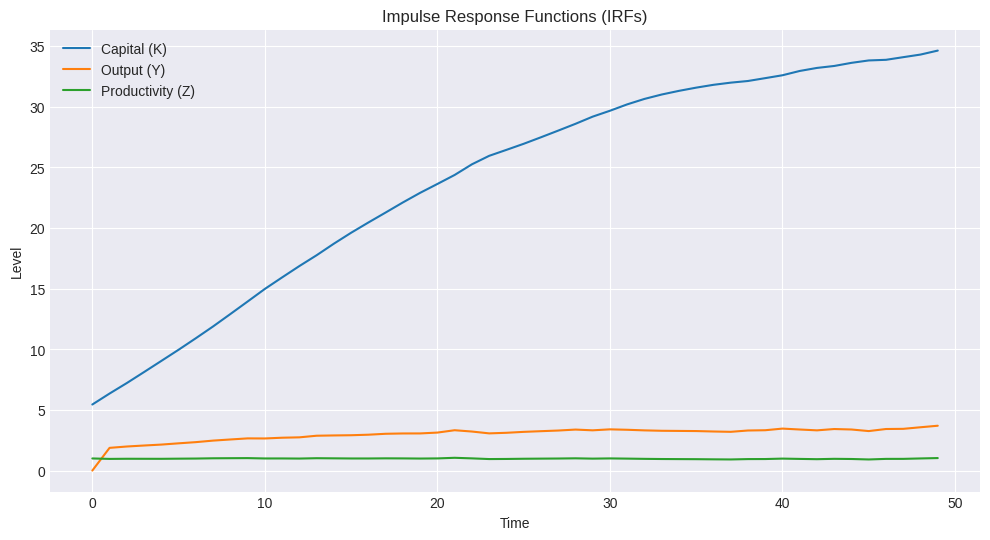


Capital Statistics:
Mean: 24.0257
Std: 8.9727
Skew: -0.6139
Kurtosis: -0.9567

Output Statistics:
Mean: 2.9774
Std: 0.6059
Skew: -2.6280
Kurtosis: 9.4071

Productivity Statistics:
Mean: 0.9820
Std: 0.0296
Skew: -0.1473
Kurtosis: -0.3166

Policy Recommendations:
Consider implementing policies to stabilize capital markets.
Fiscal policies could buffer against output volatility.

Dynamic Economic Insights:
High volatility in capital stock may lead to unstable long-term growth.
Negative skewness in output indicates risk of downturns.
High kurtosis in output suggests exposure to extreme economic events.




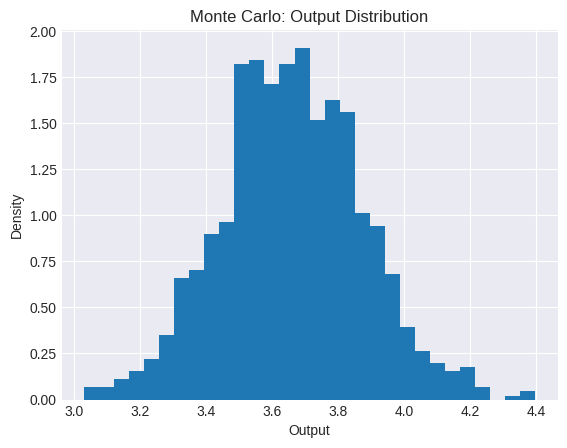



[3.435643162939383, 3.486373732075749, 3.635627211280407, 3.926442883443875, 3.4266878811747152, 3.907192694586944, 3.195540366032477, 3.09290635105456, 4.184633804745366, 3.8094129099791623]


In [9]:
# Simulate the model dynamics
simulation = RBCSimulation(model, shock)

# Evaluate the simulation with the evaluator
evaluator = RBCEvaluator(simulation)

# Analyze Impulse Response Functions (IRFs)
evaluator.impulse_response_analysis()

# Perform Monte Carlo Simulation for Output Distribution
outputs = simulation.monte_carlo()
print(outputs[:10])